In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, mixed_precision
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from IPython.display import clear_output

2025-06-17 10:57:24.386774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750157844.436459   12712 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750157844.450998   12712 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750157844.555183   12712 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750157844.555299   12712 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750157844.555301   12712 computation_placer.cc:177] computation placer alr

In [2]:
# Mixed precision (for speed)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# === PATHS ===
TRAIN_DIR = '/teamspace/studios/this_studio/car_model_detection/data/processed/train'
AUGMENTED_DIR = '/teamspace/studios/this_studio/car_model_detection/data/augmented'
VAL_DIR = '/teamspace/studios/this_studio/car_model_detection/data/processed/val'
MODEL_PATH = '/teamspace/studios/this_studio/car_model_detection/models/efficientnetb0_car_model.keras'

# === PARAMETERS ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_PHASE1 = 15
EPOCHS_PHASE2 = 50
NUM_CLASSES = len(os.listdir(TRAIN_DIR))

In [3]:
# === FOCAL LOSS ===
def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        pt = tf.exp(-ce)
        return alpha * tf.pow(1 - pt, gamma) * ce
    return loss_fn

# === CALLBACK TO DISPLAY AUGMENTED SAMPLES ===
class AugPreview(tf.keras.callbacks.Callback):
    def __init__(self, generator, samples=8):
        self.generator = generator
        self.samples = samples

    def on_epoch_end(self, epoch, logs=None):
        x, y = next(self.generator)
        plt.figure(figsize=(15, 8))
        for i in range(min(len(x), self.samples)):
            plt.subplot(2, 4, i+1)
            plt.imshow(x[i])
            plt.title(f"Class: {np.argmax(y[i])}")
            plt.axis('off')
        plt.suptitle(f'Epoch {epoch+1} - Augmented Samples')
        plt.show()
        clear_output(wait=True)

In [ ]:
# === LIVE AUGMENTATION ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_gen_live = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 840 images belonging to 4 classes.


In [ ]:
# === SAVED AUGMENTED IMAGES (STATIC) ===
augmented_ds = image_dataset_from_directory(
    AUGMENTED_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True,
    seed=42
).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

Found 3735 files belonging to 4 classes.


I0000 00:00:1750157847.968589   12712 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20974 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:35:00.0, compute capability: 8.9


In [ ]:
# === COMBINE BOTH ===
live_ds = tf.data.Dataset.from_generator(
    lambda: train_gen_live,
    output_signature=(
        tf.TensorSpec(shape=(None, *IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, NUM_CLASSES), dtype=tf.float32),
    )
)

combined_train_ds = (live_ds.concatenate(augmented_ds)
                     .shuffle(1000)
                     .prefetch(tf.data.AUTOTUNE))

# === VALIDATION DATA ===
val_datagen = ImageDataGenerator(rescale=1./255)
val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 240 images belonging to 4 classes.


In [7]:
# === CLASS WEIGHTS ===
labels = train_gen_live.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))

In [8]:
# === MODEL ===
base_model = EfficientNetB0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

model = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.Dense(512, activation='swish'),
    layers.Dropout(0.4),
    layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')
])

In [9]:
# === COMPILE MODEL ===
def lr_schedule(epoch):
    return float(1e-3 * np.exp(-0.1 * epoch))

model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5),
    loss=focal_loss(),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [10]:
# === CALLBACKS ===
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        MODEL_PATH, save_best_only=True, monitor='val_auc', mode='max'
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=10, restore_best_weights=True
    ),
    tf.keras.callbacks.LearningRateScheduler(lr_schedule),
    AugPreview(train_gen_live),
    tf.keras.callbacks.TerminateOnNaN()
]

In [11]:
# === TRAINING PHASE 1: FREEZE BASE ===
base_model.trainable = False
print("\n🔒 Phase 1: Training top layers (frozen base)")
history = model.fit(
    combined_train_ds,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE1,
    steps_per_epoch=len(train_gen_live),
    validation_steps=len(val_gen),
    class_weight=class_weights_dict,
    callbacks=callbacks
)

27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.2982 - auc: 0.5313 - loss: 0.2188 - precision: 0.3261 - recall: 0.0282 - val_accuracy: 0.2500 - val_auc: 0.5156 - val_loss: 0.1951 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.6788e-04


In [13]:
# === TRAINING PHASE 2: FINE-TUNE ENTIRE MODEL ===
if max(history.history['val_accuracy']) < 0.90:
    print("\n🔓 Phase 2: Fine-tuning full model")
    base_model.trainable = True
    model.compile(
        optimizer=AdamW(learning_rate=1e-5),
        loss=focal_loss(),
        metrics=[
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc')
]

    )
    model.fit(
        combined_train_ds,
        validation_data=val_gen,
        epochs=EPOCHS_PHASE2,
        initial_epoch=EPOCHS_PHASE1,
        steps_per_epoch=len(train_gen_live),
        validation_steps=len(val_gen),
        class_weight=class_weights_dict,
        callbacks=callbacks
    )

# === SAVE FINAL MODEL ===
model.save(MODEL_PATH)
print(f"\n✅ Done. Best val acc: {max(history.history['val_accuracy']):.2%}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 316ms/step - accuracy: 0.6893 - auc: 0.9011 - loss: 0.0987 - precision: 0.7702 - recall: 0.6112 - val_accuracy: 0.6250 - val_auc: 0.8447 - val_loss: 0.1604 - val_precision: 0.6753 - val_recall: 0.5458 - learning_rate: 7.4466e-06

✅ Done. Best val acc: 25.00%


Found 120 images belonging to 4 classes.

🔍 Evaluating model on test set...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/4 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 0.7188 - auc: 0.9377 - loss: 0.5934 - precision: 0.7241 - recall: 0.6562

2025-06-17 11:38:53.134445: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2387', 268 bytes spill stores, 268 bytes spill loads

2025-06-17 11:38:55.551574: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-17 11:38:55.659471: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-17 11:38:56.057350: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-17 11:38:56.167278: E external/local_xla/xla/

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.6662 - auc: 0.8851 - loss: 0.8260 - precision: 0.7203 - recall: 0.5944
loss: 0.9090
compile_metrics: 0.6500
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step

📊 Classification Report:
                precision    recall  f1-score   support

  honda_accord       0.64      0.70      0.67        30
       peugeot       0.75      0.60      0.67        30
  toyota_camry       0.52      0.77      0.62        30
toyota_corolla       0.84      0.53      0.65        30

      accuracy                           0.65       120
     macro avg       0.69      0.65      0.65       120
  weighted avg       0.69      0.65      0.65       120



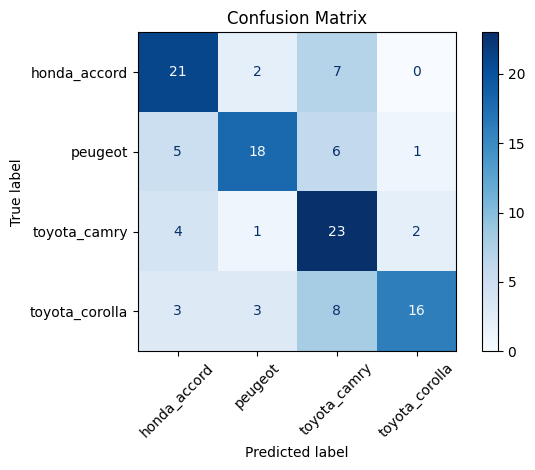

In [17]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === PATHS ===
MODEL_PATH = '/teamspace/studios/this_studio/car_model_detection/models/efficientnetb0_car_model.keras'
TEST_DIR = '/teamspace/studios/this_studio/car_model_detection/data/processed/test'  # Replace with actual test folder
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# === LOAD MODEL ===
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

# === COMPILE WITH METRICS (OPTIONAL) ===
model.compile(
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# === DATA GENERATOR FOR TEST SET ===
datagen = ImageDataGenerator(rescale=1./255)

test_gen = datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# === EVALUATE ===
print("\n🔍 Evaluating model on test set...")
results = model.evaluate(test_gen)
for name, val in zip(model.metrics_names, results):
    print(f"{name}: {val:.4f}")

# === PREDICT & CONFUSION MATRIX ===
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# === LABELS ===
class_labels = list(test_gen.class_indices.keys())

# === CLASSIFICATION REPORT ===
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
